#### Imports

In [49]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import requests
from matplotlib.cbook import boxplot_stats 
from scipy import stats

#### Variables

In [2]:
url = "https://raw.githubusercontent.com/joepollastrini/Loan-Prediction/master"
train_name = 'train_loan_data.csv'
test_name = 'test_loan_data.csv'

#### Functions

In [3]:
def data_grab_online(base, name, out='output.csv'):
    #get data from url
    u = base + '/' + name
    r = requests.get(u).content
    df = pd.read_csv(u)
    return df

***

In [4]:
#gather data
train = data_grab_online(url, train_name)
test = data_grab_online(url, test_name)

***
***
# EDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


****Train missing values:**** 
* Gender (13 / 2.1%)
* Married (3 / 0.5%)
* Dependents (15 / 2.4%)
* Self_Employed (32 / 5.2%)
* LoanAmount (22 / 3.6%)
* Loan_Amount_Term (14 / 2.3%
* Credit_History (50 / 8.1%)

****Test missing values:**** 
* Gender (11 / 1.8%)
* Dependents (10 / 2.7%)
* Self_Employed (23 / 3.7%)
* LoanAmount (5 / 1.4%)
* Loan_Amount_Term (6 / 1.6%)
* Credit_History (29 / 7.9%)

In [8]:
train.describe()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000

* Income and Loan amount have outliers, looks pretty skewed
* 84% of applicants have a credit history

***

In [9]:
def classif_eda(df, ind, dep, other='Property_Area', size=(6, 4)):
    #breakdown
    print(df[ind].value_counts(normalize=True))
    print('\n')
    print(df.groupby([ind, dep])[other].count().unstack())
    
    # countplot
    plt.figure(figsize = size)
    ax = sns.countplot(df[ind], hue = df[dep])
    
    df[ind].dropna(inplace=True)
    num_cats = len(df[ind].unique())
    num_hues = len(df[dep].unique())
    
    indices = list(range(num_cats*num_hues))
    
    patches = ax.patches
        
    cat_ix = []
    for i in range(num_cats):
        ix = indices[i::num_cats]
        cat_ix.append(ix)    
    
    for ix in cat_ix:
        total = 0
        for patch_ix in ix:
            add = patches[patch_ix].get_height()
            total = total + add
        for patch_ix in ix:
            percentage = '{:.1f}%'.format((patches[patch_ix].get_height() / total) * 100.0)
            x_pos = patches[patch_ix].get_x() + patches[patch_ix].get_width() / 2 - 0.15
            y_pos = patches[patch_ix].get_y() + patches[patch_ix].get_height() + 0.5
            ax.annotate(percentage, (x_pos, y_pos))

## Gender

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64


Loan_Status    N    Y
Gender               
Female        37   75
Male         150  339


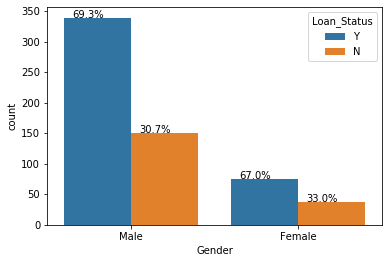

In [10]:
classif_eda(train, 'Gender', 'Loan_Status')

****Takeaways:****
* Loan is more likely to be in males name (81%)
* Gender doesn't seem to have a relationship with loan approval

***
## Married

Yes    0.651391
No     0.348609
Name: Married, dtype: float64


Loan_Status    N    Y
Married              
No            79  134
Yes          113  285


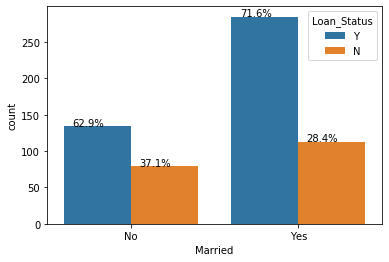

In [11]:
classif_eda(train, 'Married', 'Loan_Status')

****Takeaways:****
* Loan is more likely to be for a married couple (65%)
* Married couple has a higher probability of having loan approved
    * This may be due to dual incomes, higher total income

***
## Married and Gender

### New Variables

In [12]:
train['Gender_Married'] = train['Gender'] + '_' + train['Married']

Male_Yes      0.596990
Male_No       0.217391
Female_No     0.133779
Female_Yes    0.051839
Name: Gender_Married, dtype: float64


Loan_Status       N    Y
Gender_Married          
Female_No        29   51
Female_Yes        8   23
Male_No          49   81
Male_Yes        101  256


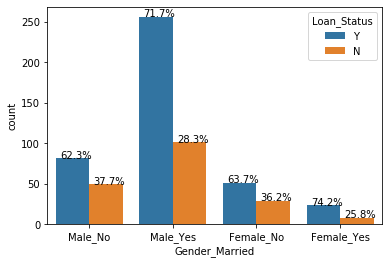

In [13]:
classif_eda(train, 'Gender_Married', 'Loan_Status')

****Takeaways:****
* Despite males having a slightly better chance of a loan approval on their own, when broken down with marriage, females have a higher chance
* Marriage still means a better chance of approval

This might be a useful variable

***
## Dependents

0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64


Loan_Status    N    Y
Dependents           
0            107  238
1             36   66
2             25   76
3+            18   33


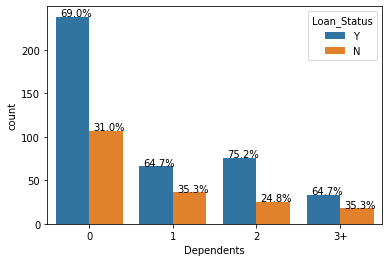

In [14]:
classif_eda(train, 'Dependents', 'Loan_Status')

****Key Takeaways:****
* Interesting relationships here

***
## Dependents and Married

### New Variables

In [15]:
train['Dependent_Married'] = train['Dependents'] + '_' + train['Married']

0_Yes     0.290484
0_No      0.285476
2_Yes     0.155259
1_Yes     0.131886
3+_Yes    0.073456
1_No      0.038397
2_No      0.013356
3+_No     0.011686
Name: Dependent_Married, dtype: float64


Loan_Status         N    Y
Dependent_Married         
0_No               61  110
0_Yes              46  128
1_No               10   13
1_Yes              26   53
2_No                3    5
2_Yes              22   71
3+_No               3    4
3+_Yes             15   29


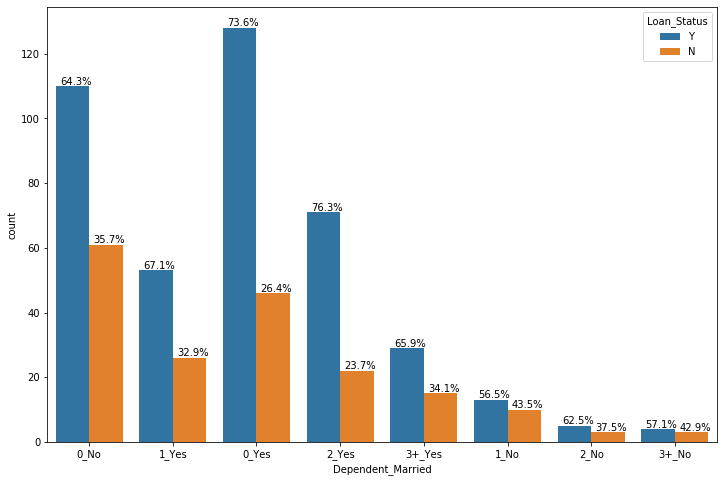

In [16]:
classif_eda(train, 'Dependent_Married', 'Loan_Status', size=(12, 8))

****Key Takeaways:****
* As dependents increase, probablity of loan approval is increasingly worse if not married

***
## Education

Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64


Loan_Status     N    Y
Education             
Graduate      140  340
Not Graduate   52   82


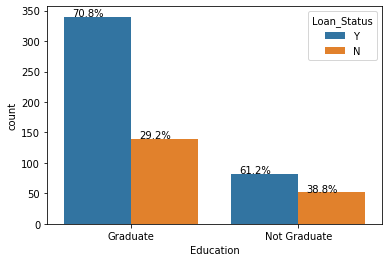

In [17]:
classif_eda(train, 'Education', 'Loan_Status')

****Key Takeaways:****
* Most have higher education (78%)
* Graduated implies better chance of loan approval

***
## Education and Dependents

### New Variables

In [18]:
train['Dependent_Education'] = train['Dependents'] + '_' + train['Education']

0_Graduate         0.459098
1_Graduate         0.135225
2_Graduate         0.128548
0_Not Graduate     0.116861
3+_Graduate        0.060100
2_Not Graduate     0.040067
1_Not Graduate     0.035058
3+_Not Graduate    0.025042
Name: Dependent_Education, dtype: float64


Loan_Status           N    Y
Dependent_Education         
0_Graduate           79  196
0_Not Graduate       28   42
1_Graduate           29   52
1_Not Graduate        7   14
2_Graduate           18   59
2_Not Graduate        7   17
3+_Graduate          11   25
3+_Not Graduate       7    8


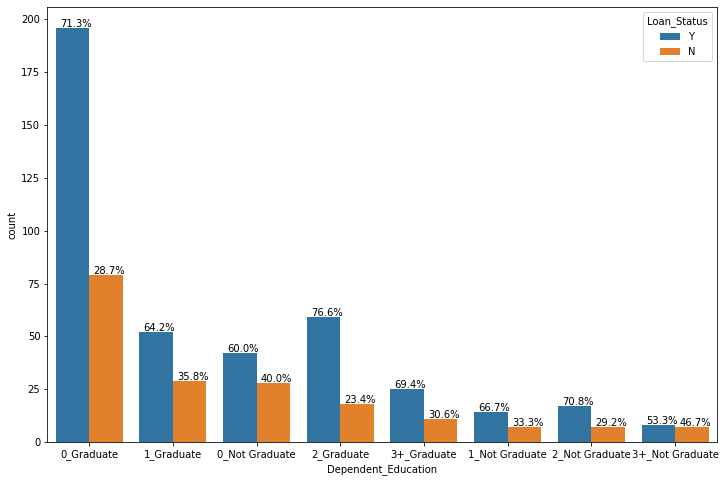

In [19]:
classif_eda(train, 'Dependent_Education', 'Loan_Status', size=(12,8))

****Key Takeaways:****
* Biggest differences in probability with 0 dependents and 3+ dependents

***
## Self Employed

In [20]:
classif_eda(train, 'Self_Employed', 'Loan_Status')

No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64


Loan_Status      N    Y
Self_Employed          
No             157  343
Yes             26   56


****Key Takeaways:****
* Very little difference between employment avenue

***
## Loan Amount Term

In [22]:
train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

* Most loans are standard 30 yr.  Next most 15 yr
* Small amounts for other loan amounts, look to group

### New Variable

In [21]:
def loanClass(x):
    if np.isnan(x):
        return np.nan
    else:
        x = int(x)
        if x == 360:
            return '30'
        elif x == 180:
            return '15'
        elif x < 180:
            return '<15'
        elif x > 180 and x < 360:
            return '(15, 30)'
        elif x > 360:
            return '>30'
        else:
            return '??'

In [23]:
train['LoanTermGroups'] = train['Loan_Amount_Term'].apply(lambda x: loanClass(x))

In [24]:
train['LoanTermGroups'].value_counts()

30          512
15           44
(15, 30)     17
>30          15
<15          12
Name: LoanTermGroups, dtype: int64

In [26]:
classif_eda(train, 'LoanTermGroups', 'Loan_Status', size=(10,7))

30          0.853333
15          0.073333
(15, 30)    0.028333
>30         0.025000
<15         0.020000
Name: LoanTermGroups, dtype: float64


Loan_Status       N    Y
LoanTermGroups          
(15, 30)          6   11
15               15   29
30              153  359
<15               3    9
>30               9    6


***
## Credit History

1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64


Loan_Status      N    Y
Credit_History         
0.0             82    7
1.0             97  378


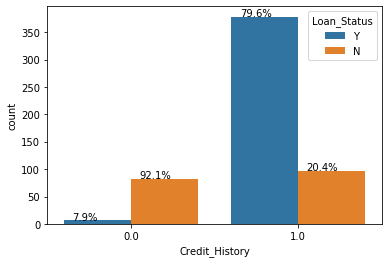

In [27]:
classif_eda(train, 'Credit_History', 'Loan_Status')

****Key Takeaways:****
* Most likely have a history (84%)
* No history means you likely were not approved
* Likely most important variable?
* Careful with imputing missing values here

***
## Property Area

Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64


Loan_Status     N    Y
Property_Area         
Rural          67  108
Semiurban      52  175
Urban          68  131


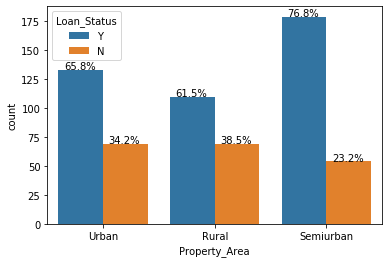

In [28]:
classif_eda(train, 'Property_Area', 'Loan_Status', 'Gender')

****Key Takeaways:****
Small discrpencies between area could be useful

***

In [122]:
def contin_eda(df, ind):
    df[ind].dropna(inplace=True)
    fig = plt.figure(figsize=(10, 9))

    #boxplot
    fig.add_subplot(3, 2, 1)
    sns.boxplot(df[ind])
    
    #distplot with outliers
    fig.add_subplot(3, 2, 3)
    sns.distplot(df[ind], kde=False, fit=stats.norm)
    
    #remove outliers
    box = boxplot_stats(df[ind])[0]
    lowVal = box['whislo']
    highVal = box['whishi']
    df['Inlier'] = df[ind].apply(lambda x: 1 if (x > lowVal and x < highVal) else 0)
    inliers = df.loc[df['Inlier'] == 1]
    
    #distplot without outliers
    fig.add_subplot(3, 2, 5)
    sns.distplot(inliers[ind], kde=False, fit=stats.norm)
    
    ## log values ##    
    #boxplot of logged values
    fig.add_subplot(3, 2, 2 )
    df[ind].dropna(inplace=True)
    sns.boxplot(np.log(df[ind]))
    
    #distplot logged with outliers
    fig.add_subplot(3, 2, 4)
    sns.distplot(np.log(df[ind]), kde=False, fit=stats.norm)
    
    #remove outliers
    box = boxplot_stats(np.log(df[ind]))[0]
    lowVal = box['whislo']
    highVal = box['whishi']
    df['Logged'] = np.log(df[ind])
    df['InlierLog'] = df['Logged'].apply(lambda x: 1 if (x > lowVal and x < highVal) else 0)
    inliers = df.loc[df['InlierLog'] == 1]
    
    #distplot logged without outliers
    fig.add_subplot(3, 2, 6)
    sns.distplot(inliers['Logged'], kde=False, fit=stats.norm)

***
## Income

In [123]:
contin_eda(train, 'TotalIncome')

* Will have to try model working with/without outliers
* Will have to try model working with logged income values

### New Variables

In [31]:
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['IncomeQuart'] = pd.qcut(train['TotalIncome'], 4, labels = ['IncomeQ1', 'IncomeQ2', 'IncomeQ3', 'IncomeQ4'])
train['IncomeDec'] = pd.qcut(train['TotalIncome'], 10)

IncomeQ1    0.252443
IncomeQ4    0.250814
IncomeQ3    0.249186
IncomeQ2    0.247557
Name: IncomeQuart, dtype: float64


Loan_Status   N    Y
IncomeQuart         
IncomeQ1     50  105
IncomeQ2     48  104
IncomeQ3     44  109
IncomeQ4     50  104


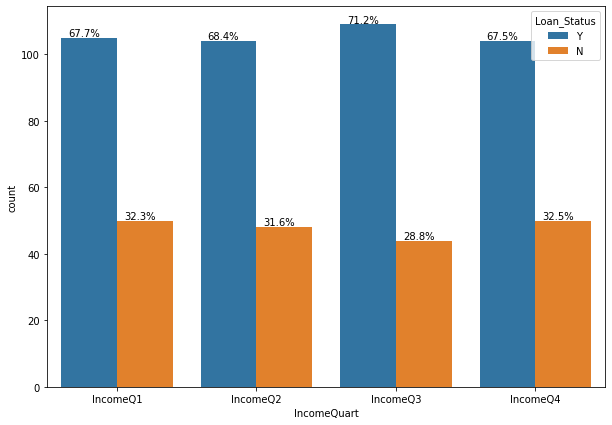

In [33]:
classif_eda(train, 'IncomeQuart', 'Loan_Status', size=(10,7))

* Quartiles have a similar breakdown

In [34]:
classif_eda(train, 'IncomeDec', 'Loan_Status', size=(10,7))

(11462.8, 81000.0]    0.100977
(6787.2, 8334.0]      0.100977
(6042.6, 6787.2]      0.100977
(4402.7, 4807.4]      0.100977
(1441.999, 3245.8]    0.100977
(5416.5, 6042.6]      0.099349
(4807.4, 5416.5]      0.099349
(3812.6, 4402.7]      0.099349
(3245.8, 3812.6]      0.099349
(8334.0, 11462.8]     0.097720
Name: IncomeDec, dtype: float64


Loan_Status          N   Y
IncomeDec                 
(1441.999, 3245.8]  24  38
(3245.8, 3812.6]    19  42
(3812.6, 4402.7]    16  45
(4402.7, 4807.4]    21  41
(4807.4, 5416.5]    18  43
(5416.5, 6042.6]    14  47
(6042.6, 6787.2]    22  40
(6787.2, 8334.0]    19  43
(8334.0, 11462.8]   16  44
(11462.8, 81000.0]  23  39


* Deciles have an interesting repeating pattern, but can't really utilize/explain, could just be a coincidence with this train set

***
## Loan Amount

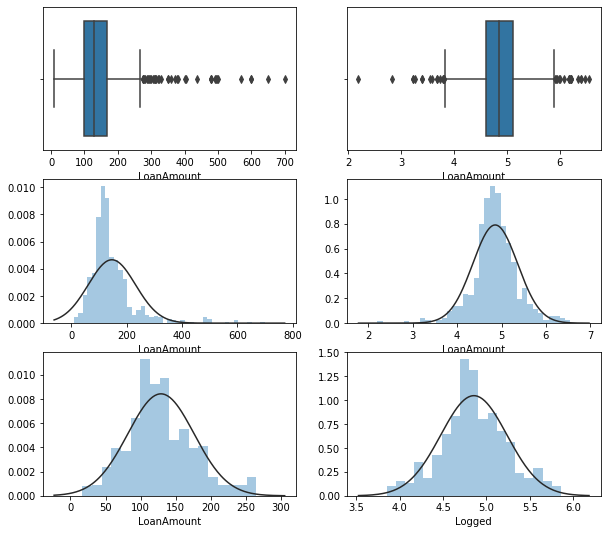

In [124]:
contin_eda(train, 'LoanAmount')

***
***
# Feature Engineering EDA

***
## Dual Income Indicator

In [91]:
def dual_ind(x):
    if x['Married'] == 'Yes':
        if x['CoapplicantIncome'] > 0:
            return 1
        else:
            return 0
    else:
        return 0

In [94]:
train['DualIncome_IO'] = train.apply(lambda x: dual_ind(x), axis=1)

In [95]:
classif_eda(train, 'DualIncome_IO', 'Loan_Status')

0    0.560261
1    0.439739
Name: DualIncome_IO, dtype: float64


Loan_Status      N    Y
DualIncome_IO          
0              119  225
1               73  197


****Key Takeaways:****
1. A little better chance of loan approval if dual income

***
## Loan Amount per Income
1. Loan amount divided by income

In [56]:
train['LoanPerIncome'] = train['LoanAmount'] * 1000 / train['TotalIncome']

In [57]:
train['LoanIncomeQuart'] = pd.qcut(train['LoanPerIncome'], 4, labels = ['LIQ1', 'LIQ2', 'LIQ3', 'LIQ4'])
sns.countplot(train['LoanIncomeQuart'], hue=train['Loan_Status'])

In [58]:
rel = train[['LoanIncomeQuart', 'Loan_Status']]
for u in ['LIQ1', 'LIQ2', 'LIQ3', 'LIQ4']:
    x = rel.loc[rel['LoanIncomeQuart']==u]['Loan_Status'].value_counts(normalize=True)
    print('{}: \n{}'.format(u,x))

LIQ1: 
Y    0.689189
N    0.310811
Name: Loan_Status, dtype: float64
LIQ2: 
Y    0.689189
N    0.310811
Name: Loan_Status, dtype: float64
LIQ3: 
Y    0.722973
N    0.277027
Name: Loan_Status, dtype: float64
LIQ4: 
Y    0.675676
N    0.324324
Name: Loan_Status, dtype: float64


****Key Takeaways:****
* Hard to tell if predictive/a relationship

***
## Loan Amount Per Year Per Term
1. Loan Amount / Term == amnt per year
2. divide that by income

In [59]:
train['LoanPerYear'] = (train['LoanAmount'] * 1000 / train['Loan_Amount_Term']) * 12
train['LoanEquity/Year'] = train['LoanPerYear'] / train['TotalIncome']

In [60]:
train['LoanIncomeYearQuart'] = pd.qcut(train['LoanEquity/Year'], 4, labels = ['LIyQ1', 'LIyQ2', 'LIyQ3', 'LIyQ4'])
sns.countplot(train['LoanIncomeYearQuart'], hue=train['Loan_Status'])

In [61]:
train['LoanEquity/Year'].describe()

count    578.000000
mean       0.931099
std        0.969483
min        0.084097
25%        0.666949
50%        0.829344
75%        0.980957
max       14.842478
Name: LoanEquity/Year, dtype: float64

In [62]:
rel = train[['LoanIncomeYearQuart', 'Loan_Status']]
for u in ['LIyQ1', 'LIyQ2', 'LIyQ3', 'LIyQ4']:
    x = rel.loc[rel['LoanIncomeYearQuart']==u]['Loan_Status'].value_counts(normalize=True)
    print('{}: \n{}'.format(u,x))

LIyQ1: 
Y    0.662069
N    0.337931
Name: Loan_Status, dtype: float64
LIyQ2: 
Y    0.708333
N    0.291667
Name: Loan_Status, dtype: float64
LIyQ3: 
Y    0.743056
N    0.256944
Name: Loan_Status, dtype: float64
LIyQ4: 
Y    0.675862
N    0.324138
Name: Loan_Status, dtype: float64


****Key Takeaway:****
* Unexpected, as total income used for loan per year goes up, so does your probablity of getting approved for loan, until 4th quartile?